Epoch 1: D=1.0656, G=10.2140
Epoch 2: D=0.8811, G=7.4499
Epoch 3: D=0.8611, G=6.8507
Epoch 4: D=0.8589, G=6.4621
Epoch 5: D=0.8488, G=6.4894
Epoch 6: D=0.8534, G=6.4135
Epoch 7: D=0.8723, G=6.1967
Epoch 8: D=0.8693, G=6.3434
Epoch 9: D=0.8490, G=6.3114
Epoch 10: D=0.8652, G=5.8898
Epoch 11: D=0.8538, G=5.8964
Epoch 12: D=0.8401, G=5.9208
Epoch 13: D=0.8436, G=5.6996
Epoch 14: D=0.8431, G=5.6312
Epoch 15: D=0.8315, G=5.7660
Epoch 16: D=0.8232, G=5.8705
Epoch 17: D=0.8429, G=5.5624
Epoch 18: D=0.8398, G=5.5499
Epoch 19: D=0.8457, G=5.7861
Epoch 20: D=0.8276, G=5.7495
Epoch 21: D=0.8456, G=5.5023
Epoch 22: D=0.8307, G=5.8109
Epoch 23: D=0.8589, G=5.5557
Epoch 24: D=0.8383, G=5.6176
Epoch 25: D=0.8333, G=5.7607
Epoch 26: D=0.8184, G=5.8328
Epoch 27: D=0.8570, G=5.4932
Epoch 28: D=0.8538, G=5.3848
Epoch 29: D=0.8414, G=5.4666
Epoch 30: D=0.8513, G=5.4631
Epoch 31: D=0.8730, G=5.2866
Epoch 32: D=0.7988, G=5.8066
Epoch 33: D=0.8587, G=5.4932
Epoch 34: D=0.8705, G=5.3938
Epoch 35: D=0.8817, G=

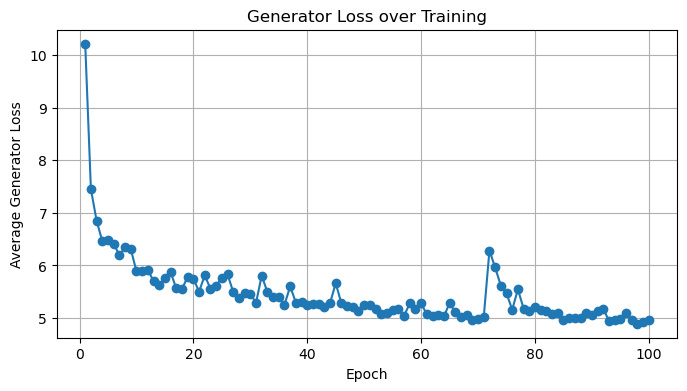

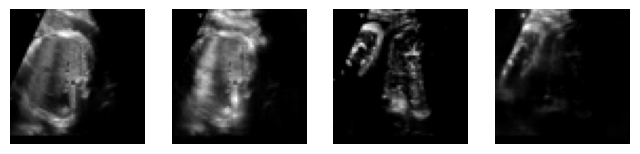

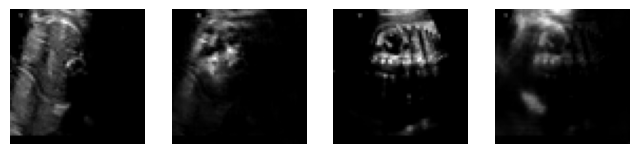

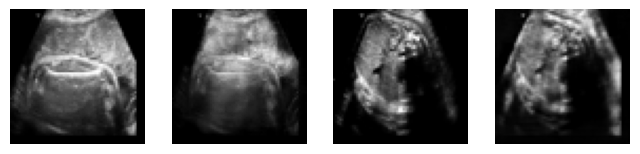

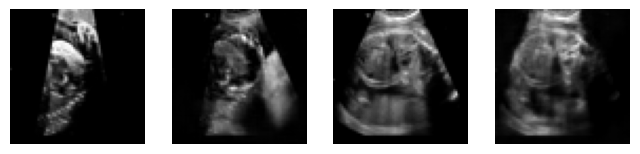

In [ ]:
import os, glob, math, argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.models import vgg16, VGG16_Weights
import matplotlib.pyplot as plt

# -----------------------------
# 1) Dataset for unpaired images
# -----------------------------
class Ultrasounddataset(Dataset):
    def __init__(self, root_A, root_B, size):
        exts = ('*.jpg','*.jpeg','*.png')
        self.paths_A = sum([glob.glob(os.path.join(root_A, '**', e), recursive=True)
                            for e in exts], [])
        self.paths_B = sum([glob.glob(os.path.join(root_B, '**', e), recursive=True)
                            for e in exts], [])
        self.paths_A.sort(); self.paths_B.sort()
        self.size = size

    def __len__(self):
        return max(len(self.paths_A), len(self.paths_B))

    def __getitem__(self, idx):
        path_A = self.paths_A[idx % len(self.paths_A)]
        path_B = self.paths_B[idx % len(self.paths_B)]
        img_A = Image.open(path_A).convert('L').resize((self.size, self.size))
        img_B = Image.open(path_B).convert('L').resize((self.size, self.size))
        tf = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
        return tf(img_A), tf(img_B)

# -----------------------------
# 2) Sinusoidal time embedding
# -----------------------------
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half = self.dim // 2
        freq = math.log(10000) / (half - 1)
        freqs = torch.exp(torch.arange(half, device=t.device) * -freq)
        args = t[:, None] * freqs[None]
        emb = torch.cat([args.sin(), args.cos()], dim=1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1))
        return emb

# -----------------------------
# 3) Convolutional Block
# -----------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, up=False):
        super().__init__()
        self.conv1  = nn.Conv2d(in_ch, in_ch, 3, 1, 1, groups=in_ch)
        self.point1 = nn.Conv2d(in_ch, out_ch, 1)
        self.norm1  = nn.GroupNorm(4, out_ch)
        self.act1   = nn.ReLU(inplace=True)
        self.time_proj = nn.Linear(time_dim, out_ch)
        Conv2 = nn.ConvTranspose2d if up else nn.Conv2d
        self.conv2 = Conv2(out_ch, out_ch, 3, 1, 1)
        self.norm2 = nn.GroupNorm(4, out_ch)
        self.act2  = nn.ReLU(inplace=True)

    def forward(self, x, t_emb):
        h = self.act1(self.norm1(self.point1(self.conv1(x))))
        t = self.time_proj(t_emb).view(-1, h.size(1), 1, 1)
        h = h + t
        h = self.act2(self.norm2(self.conv2(h)))
        return h

# -----------------------------
# 4) DDPM U-Net generator
# -----------------------------
class TimeConditionedUNet(nn.Module):
    def __init__(self, in_ch=1, base=16, time_dim=32, depth=4):
        super().__init__()
        self.time_emb = SinusoidalTimeEmbedding(time_dim)
        skip_chs = [base * (2**i) for i in range(depth)]
        self.downs = nn.ModuleList()
        ch = in_ch
        for out_ch in skip_chs:
            self.downs.append(ConvBlock(ch, out_ch, time_dim, up=False))
            ch = out_ch
        self.bottleneck = nn.Sequential(
            nn.Conv2d(ch, ch*2, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(ch*2, ch, 3, padding=1), nn.ReLU(inplace=True),
        )
        self.ups = nn.ModuleList()
        for skip in reversed(skip_chs):
            self.ups.append(ConvBlock(ch + skip, skip, time_dim, up=True))
            ch = skip
        self.final = nn.Conv2d(ch, in_ch, 1)

    def forward(self, x, t):
        t_emb = self.time_emb(t)
        skips = []; h = x
        for down in self.downs:
            h = down(h, t_emb); skips.append(h)
            h = F.avg_pool2d(h, 2)
        h = self.bottleneck(h)
        for up in self.ups:
            h = F.interpolate(h, scale_factor=2, mode='nearest')
            h = torch.cat([h, skips.pop()], dim=1)
            h = up(h, t_emb)
        return self.final(h)

# -----------------------------
# 5) PatchGAN discriminator
# -----------------------------
class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=1, base=16, num_layers=4):
        super().__init__()
        layers = []; ch = in_ch
        for i in range(num_layers):
            out = base * (2**i)
            layers += [nn.Conv2d(ch, out, 4, 2, 1),
                       nn.LeakyReLU(0.2, inplace=True)]
            ch = out
        layers.append(nn.Conv2d(ch, 1, 4, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# -----------------------------
# 6) Training with DDPM + CycleGAN losses
# -----------------------------
def train(args):
    device = args.device

    betas = torch.linspace(1e-4, 0.02, args.timesteps, device=device)
    alphas = 1 - betas
    alphas_cum = torch.cumprod(alphas, dim=0)
    def q_sample(x0, t, noise):
        a = alphas_cum[t].view(-1,1,1,1)
        return a.sqrt()*x0 + (1-a).sqrt()*noise

    ds = Ultrasounddataset(args.dataA, args.dataB, args.size)
    if len(ds)==0:
        raise RuntimeError("No images in folders.")
    dl = DataLoader(ds, batch_size=args.batch, shuffle=True)

    Gf = TimeConditionedUNet(1,args.base,args.time_dim,args.unet_depth).to(device)
    Gb = TimeConditionedUNet(1,args.base,args.time_dim,args.unet_depth).to(device)
    Df = PatchDiscriminator(1,args.base,args.disc_layers).to(device)
    Db = PatchDiscriminator(1,args.base,args.disc_layers).to(device)
    opt_G = optim.Adam(list(Gf.parameters())+list(Gb.parameters()),lr=args.lr, betas=(0.5,0.999))
    opt_D = optim.Adam(list(Df.parameters())+list(Db.parameters()), lr=args.lr_d, betas=(0.5,0.999))

    mse, l1 = nn.MSELoss(), nn.L1Loss()

    layer_ids = [3,8,15,22,29]
    w_i = torch.tensor([1,.75,.5,.25,.1],device=device)
    vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features.to(device).eval()
    for p in vgg.parameters(): p.requires_grad_(False)
    def phi_loss(x,y):
        def prep(t): return F.interpolate(t.repeat(1,3,1,1), size=224, mode='bilinear', align_corners=False)
        fx,fy = [],[]
        h = prep(x)
        for i,l in enumerate(vgg):
            h = l(h)
            if i in layer_ids: fx.append(h)
        h = prep(y)
        for i,l in enumerate(vgg):
            h = l(h)
            if i in layer_ids: fy.append(h)
        dists = [F.mse_loss(a,b,reduction='none')
                     .mean([1,2,3]).sqrt()
                 for a,b in zip(fx,fy)]
        return (torch.stack(dists,1) @ w_i).mean()


    gen_losses = []
    T = args.timesteps
    for ep in range(1, args.epochs+1):
        sum_D = sum_G = 0.0
        for realA, realB in dl:
            realA, realB = realA.to(device), realB.to(device)


            with torch.no_grad():
                fakeB_det = Gf(realA, torch.rand(realA.size(0),device=device))
                fakeA_det = Gb(realB, torch.rand(realB.size(0),device=device))
            loss_D = (
                mse(Df(realB), torch.ones_like(Df(realB))) +
                mse(Df(fakeB_det), torch.zeros_like(Df(fakeB_det))) +
                mse(Db(realA), torch.ones_like(Db(realA))) +
                mse(Db(fakeA_det), torch.zeros_like(Db(fakeA_det)))
            )
            opt_D.zero_grad(); loss_D.backward(); opt_D.step()


            eps      = torch.randn_like(realA)
            t_ddpm   = torch.randint(0, T, (realA.size(0),), device=device)
            x_noisy  = q_sample(realA, t_ddpm, eps)
            pred_eps = Gf(x_noisy, t_ddpm.float()/(T-1))
            ddpm_loss= mse(pred_eps, eps)

            t_norm   = torch.randint(0, T, (realA.size(0),), device=device).float()/(T-1)
            fakeB    = Gf(realA, t_norm)
            fakeA    = Gb(realB, t_norm)
            adv_loss = (mse(Df(fakeB), torch.ones_like(Df(fakeB)))
                      + mse(Db(fakeA), torch.ones_like(Db(fakeA))))
            cyc_loss = (l1(Gb(fakeB, t_norm), realA)
                      + l1(Gf(fakeA, t_norm), realB))
            id_loss  = (l1(Gb(realA, torch.zeros_like(t_norm)), realA)
                      + l1(Gf(realB, torch.zeros_like(t_norm)), realB))
            per_loss = phi_loss(fakeB, realB) + phi_loss(fakeA, realA)

            loss_G = (
                args.lambda_adv   * adv_loss  +
                args.lambda_cycle * cyc_loss  +
                args.lambda_id    * id_loss   +
                args.lambda_per   * per_loss  +
                args.lambda_ddpm  * ddpm_loss
            )
            opt_G.zero_grad(); loss_G.backward(); opt_G.step()

            sum_D += loss_D.item()
            sum_G += loss_G.item()

        avg_G = sum_G / len(dl)
        gen_losses.append(avg_G)
        print(f"Epoch {ep}: D={sum_D/len(dl):.4f}, G={avg_G:.4f}")

    # 6.6) plot generator loss curve
    plt.figure(figsize=(8,4))
    plt.plot(range(1, args.epochs+1), gen_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Generator Loss')
    plt.title('Generator Loss over Training')
    plt.grid(True)
    plt.show()

    # 6.7) quick visual check
    realA, realB = next(iter(dl))
    realA, realB = realA.to(device), realB.to(device)
    with torch.no_grad():
        t_vis = torch.rand(realA.size(0), device=device)
        fakeB_vis = Gf(realA, t_vis)
        fakeA_vis = Gb(realB, t_vis)
    def unnorm(x): return (x.clamp(-1,1)*0.5 + 0.5).cpu().squeeze().numpy()
    for i in range(min(4, realA.size(0))):
        fig, ax = plt.subplots(1,4,figsize=(8,2))
        ax[0].imshow(unnorm(realA[i:i+1]), cmap='gray'); ax[0].axis('off')
        ax[1].imshow(unnorm(fakeB_vis[i:i+1]), cmap='gray'); ax[1].axis('off')
        ax[2].imshow(unnorm(realB[i:i+1]), cmap='gray'); ax[2].axis('off')
        ax[3].imshow(unnorm(fakeA_vis[i:i+1]), cmap='gray'); ax[3].axis('off')
        plt.show()

# -----------------------------
# 7) Utils
# -----------------------------
if __name__=='__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataA',default='Domain A')
    parser.add_argument('--dataB',default='Domain B')
    parser.add_argument('--size', type=int,default=64)
    parser.add_argument('--base',type=int, default=32)
    parser.add_argument('--time_dim',  type=int, default=32)
    parser.add_argument('--unet_depth', type=int,default=4)
    parser.add_argument('--disc_layers',type=int, default=4)
    parser.add_argument('--batch', type=int, default=4)
    parser.add_argument('--epochs', type=int, default=100)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--lr_d',type=float, default=2e-5)
    parser.add_argument('--lambda_adv', type=float, default=1.0)
    parser.add_argument('--lambda_cycle', type=float, default=10.0)
    parser.add_argument('--lambda_id', type=float, default=3.0)
    parser.add_argument('--lambda_per', type=float, default=1.0)
    parser.add_argument('--lambda_ddpm',type=float,default=3.0)
    parser.add_argument('--timesteps', type=int,default=1000)
    parser.add_argument('--device',default='cuda' if torch.cuda.is_available() else 'cpu')
    args,_ = parser.parse_known_args()

    train(args)
